In [1]:
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dropout, Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

import tensorflow as tf


In [2]:
drive.mount("my-drive")

Mounted at my-drive


# Load Dataset

### Read

In [3]:
file_name = "my-drive/MyDrive/ACB_2015.csv"

df = pd.read_csv(file_name)

print(df)

      index        date   high    low   open  close  adjust   volume
0      2015  2015-01-05  15.40  15.20  15.40  15.30    4.39    55890
1      2016  2015-01-06  15.50  15.10  15.20  15.50    4.45    89802
2      2017  2015-01-07  16.00  15.50  15.50  15.70    4.50   232912
3      2018  2015-01-08  15.80  15.60  15.70  15.80    4.53    14920
4      2019  2015-01-09  16.30  15.60  15.80  15.90    4.56   693623
...     ...         ...    ...    ...    ...    ...     ...      ...
1947   3962  2022-10-26  20.90  20.20  20.60  20.65   20.65  2716100
1948   3963  2022-10-27  22.05  20.50  20.70  22.05   22.05  4846000
1949   3964  2022-10-28  22.55  22.05  22.40  22.30   22.30  3811700
1950   3965  2022-10-31  22.50  21.65  22.35  22.40   22.40  3827300
1951   3966  2022-11-01  23.00  22.35  22.50  22.45   22.45  3355400

[1952 rows x 8 columns]


In [4]:
print(df['close'])

0       15.30
1       15.50
2       15.70
3       15.80
4       15.90
        ...  
1947    20.65
1948    22.05
1949    22.30
1950    22.40
1951    22.45
Name: close, Length: 1952, dtype: float64


### Visualization


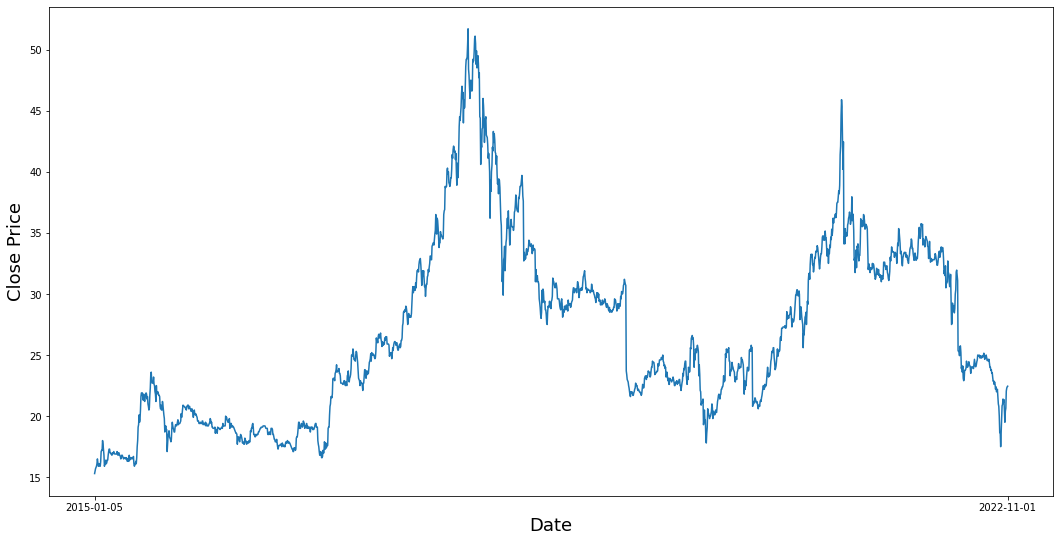

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['close']))
plt.xticks(range(0,df.shape[0],1951),df['date'].loc[::1951])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

# Split Train & Validation & Test

In [6]:
prices = df['close'].to_numpy()

df_length = df.shape[0]
train_length = df_length * 90 // 100
test_length = df_length * 10 // 100

print("Train: {} \n\nTest: {}".format(train_length, test_length))

train_data = prices[:train_length]
test_data = prices[train_length:]

Train: 1756 

Test: 195


# Process

## One-Step Ahead Prediction via Averaging

###  Standard Average 

In [7]:
window_size = 20
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

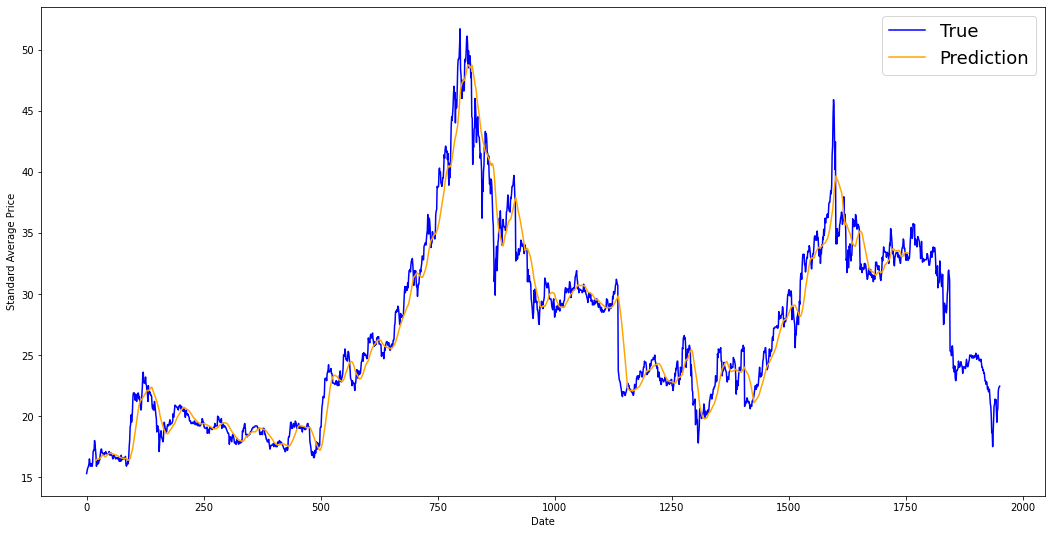

In [8]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),df['close'],color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Standard Average Price')
plt.legend(fontsize=18)
plt.show()

### Exponential Moving Average

In [9]:
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.30156


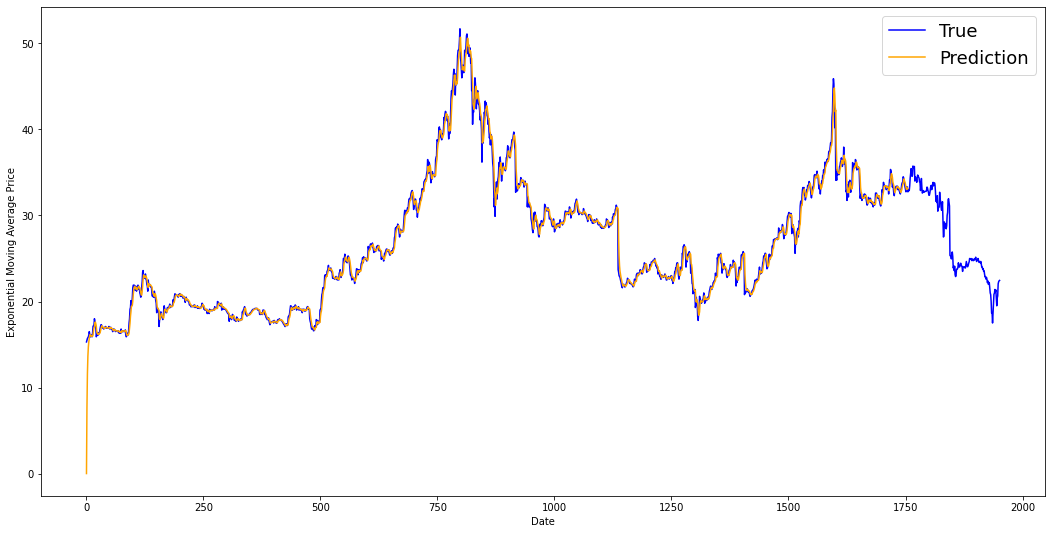

In [10]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),df['close'],color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Exponential Moving Average Price')
plt.legend(fontsize=18)
plt.show()

### Find baseline

In [11]:
def find_base_line(file_name, stock_name):
  df = pd.read_csv(file_name).sort_values('date')
  prices = df['close'].to_numpy()

  df_length = df.shape[0]
  train_length = df_length * 90 // 100
  test_length = df_length * 10 // 100

  train_data = prices[:train_length]
  test_data = prices[train_length:]

  N = test_data.size

  run_avg_predictions = []
  run_avg_x = []

  mse_errors = []

  running_mean = df['close'][train_length]
  run_avg_predictions.append(running_mean)

  decay = 0.5

  for pred_idx in range(1,N):
      running_mean = running_mean*decay + (1.0-decay)*test_data[pred_idx-1]
      run_avg_predictions.append(running_mean)
      mse_errors.append((run_avg_predictions[-1]-test_data[pred_idx])**2)
      run_avg_x.append(date)

  plt.figure(figsize = (18,9))
  plt.plot(range(test_length+1),df[train_length:]['close'],color='b',label='True')
  plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
  plt.xlabel(stock_name)
  plt.ylabel('Exponential Moving Average Price')
  plt.legend(fontsize=18)
  plt.show()

  print("\n")
  print("============== {} ==============".format(stock_name))
  print("MSE: {}".format(mean_squared_error(df[train_length:]['close'], run_avg_predictions)))
  print("MAPE: {}".format(mean_absolute_percentage_error(df[train_length:]['close'], run_avg_predictions)))
  print("MAE: {}".format(mean_absolute_error(df[train_length:]['close'], run_avg_predictions)))
  print("\n")


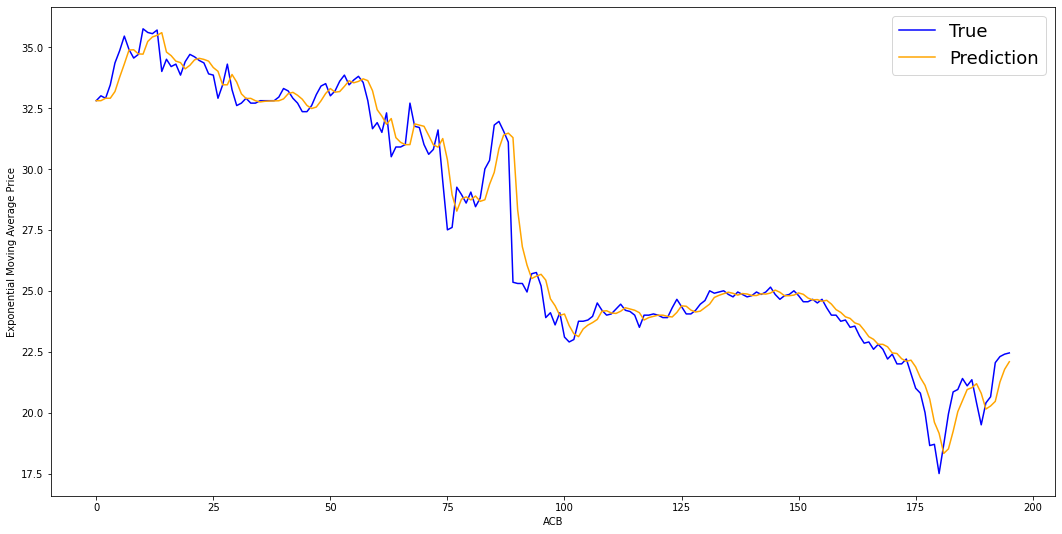



============== ACB ==============
MSE: 0.6614999304948128
MAPE: 0.01906169455873519
MAE: 0.4984691177502367




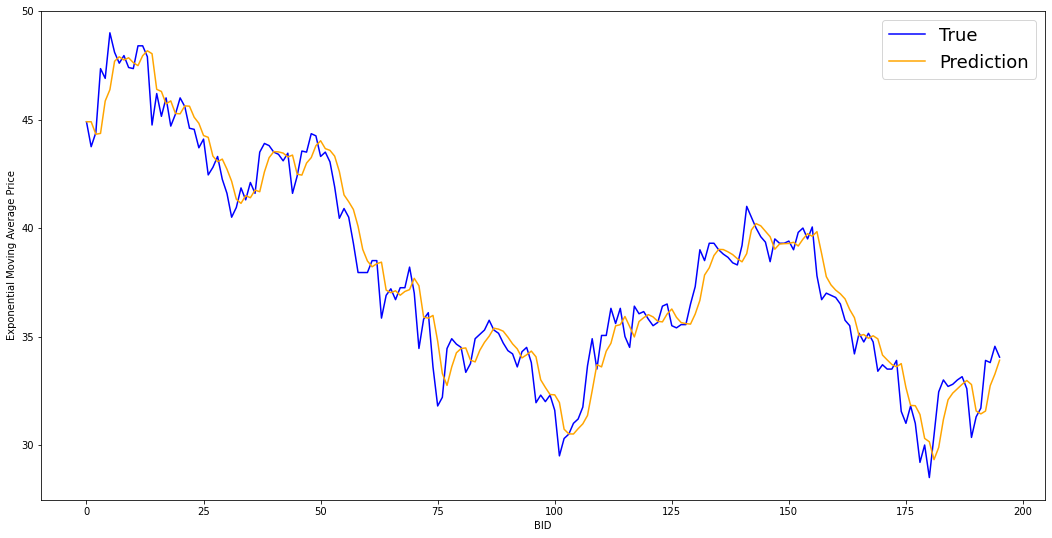



============== BID ==============
MSE: 1.185047748334583
MAPE: 0.021884175257307032
MAE: 0.8046432275052601




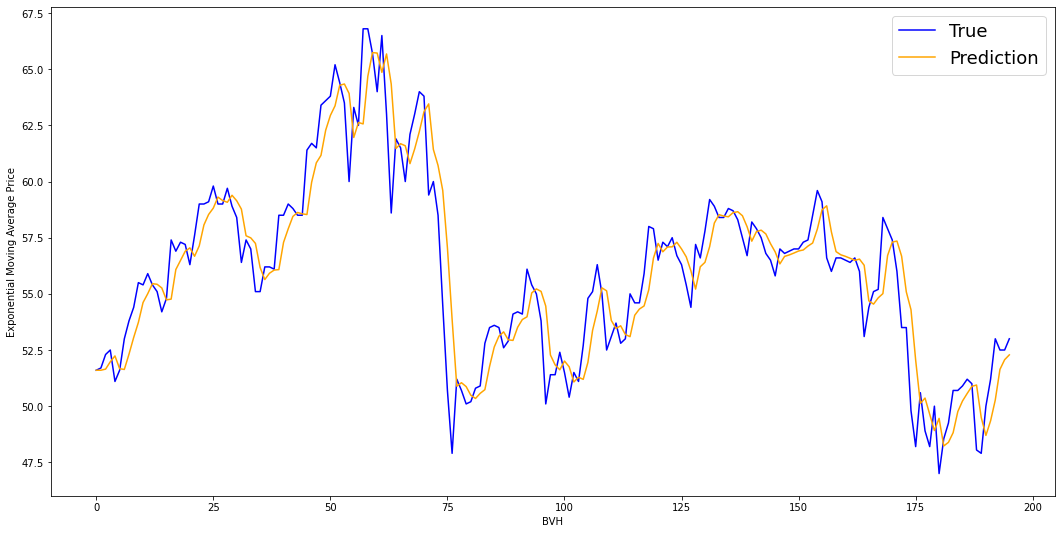



============== BVH ==============
MSE: 2.7125056332571407
MAPE: 0.02107975804785593
MAE: 1.1681369717354158




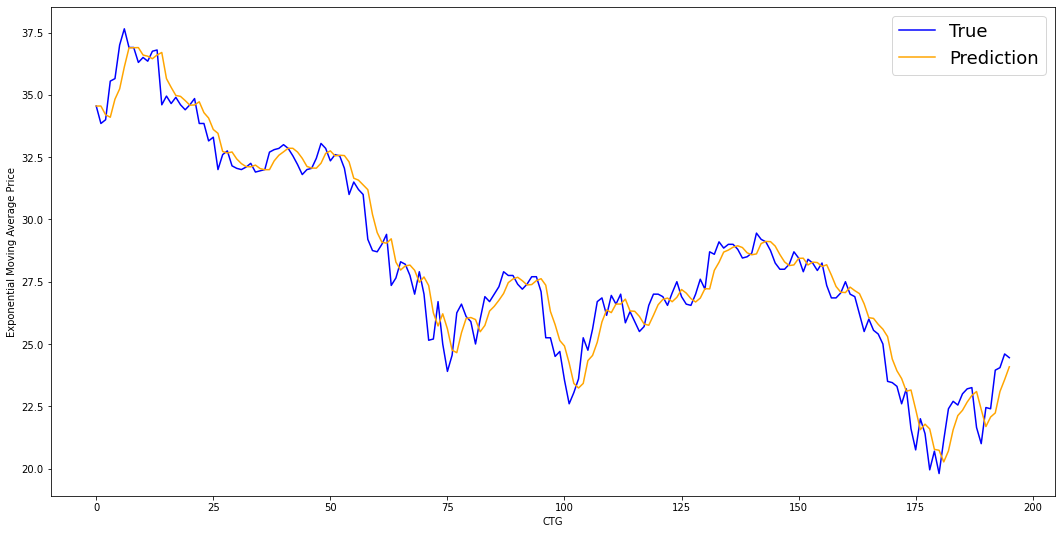



============== CTG ==============
MSE: 0.6312770355940822
MAPE: 0.02247038206586915
MAE: 0.5995714649055054




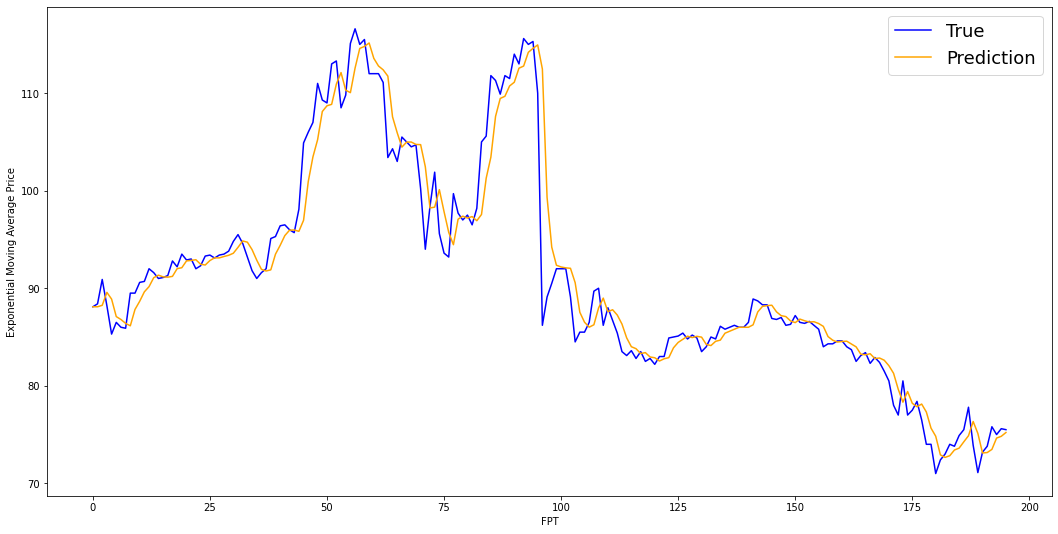



============== FPT ==============
MSE: 9.37720161942165
MAPE: 0.01860932978087955
MAE: 1.722841023753323




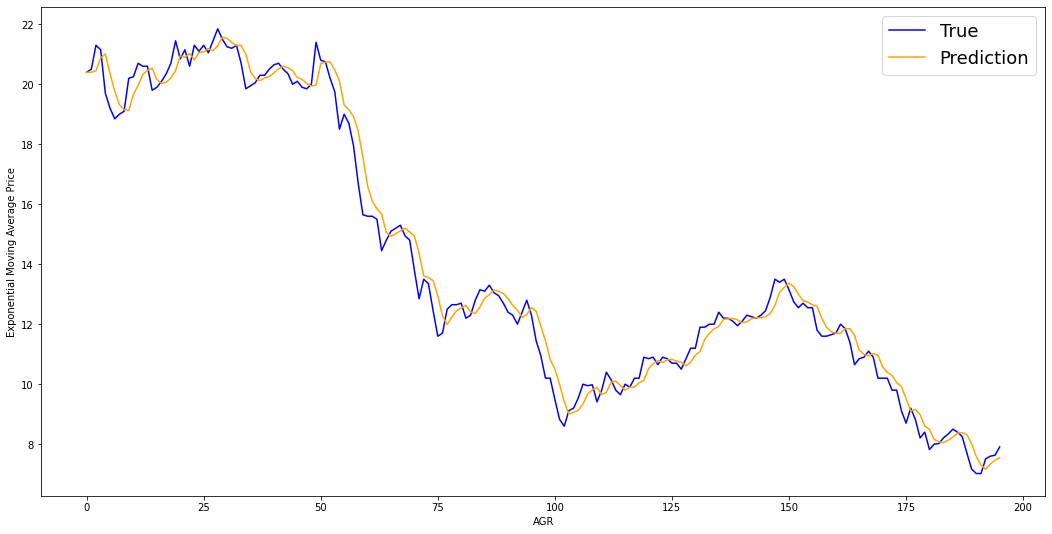



============== AGR ==============
MSE: 0.3038876800543732
MAPE: 0.03193963118481916
MAE: 0.40914948454483696




In [12]:
stock_list = ["ACB", "BID", "BVH", "CTG", "FPT", "AGR"]
file_name_list = []

for s in stock_list:
  file_name_list.append("my-drive/MyDrive/" + s + "_2015.csv")


for i in range(0, len(file_name_list)):
  find_base_line(file_name_list[i], stock_list[i])


## LSTM

In [13]:
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [14]:
time_steps = 3
x_train = []
y_train = []

for i in range(time_steps, train_data.shape[0]):
    x_train.append(train_data[i - time_steps:i])
    y_train.append(train_data[i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)



x_test = []
y_test = []

for i in range(time_steps, test_data.shape[0]):
    x_test.append(test_data[i - time_steps:i])
    y_test.append(test_data[i, 0])

x_test = np.array(x_test)
y_test = np.array(y_test)

In [15]:
model = Sequential()
# 1st layer with Dropout regularisation
# * units = add 100 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
# * input_shape => Shape of the training dataset
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# 20% of the layers will be dropped
model.add(Dropout(0.2))
# 2nd LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
model.add(LSTM(units=50, return_sequences=True))
# 20% of the layers will be dropped
model.add(Dropout(0.2))
# 3rd LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
model.add(LSTM(units=50, return_sequences=True))
# 50% of the layers will be dropped
model.add(Dropout(0.5))
# 4th LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
model.add(LSTM(units=50))
# 50% of the layers will be dropped
model.add(Dropout(0.5))
# Dense layer that specifies an output of one unit
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 3, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 50)             30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [16]:
defined_metrics = [
    tf.keras.metrics.MeanSquaredError(name='MSE')
]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=defined_metrics)
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test),
                    callbacks=[callback])

Epoch 1/100
55/55 [==============================] - 15s 76ms/step - loss: 535.8615 - MSE: 684.4067 - val_loss: 269.7403 - val_MSE: 522.3421
Epoch 2/100
55/55 [==============================] - 3s 59ms/step - loss: 236.0524 - MSE: 433.0035 - val_loss: 180.0815 - val_MSE: 374.9469
Epoch 3/100
55/55 [==============================] - 3s 61ms/step - loss: 169.2991 - MSE: 335.7078 - val_loss: 122.9548 - val_MSE: 304.5034
Epoch 4/100
55/55 [==============================] - 3s 61ms/step - loss: 129.0049 - MSE: 280.2226 - val_loss: 86.6601 - val_MSE: 259.3819
Epoch 5/100
55/55 [==============================] - 3s 61ms/step - loss: 105.3637 - MSE: 242.2609 - val_loss: 62.8196 - val_MSE: 227.6003
Epoch 6/100
55/55 [==============================] - 3s 61ms/step - loss: 87.0375 - MSE: 214.7794 - val_loss: 48.0487 - val_MSE: 203.4221
Epoch 7/100
55/55 [==============================] - 5s 83ms/step - loss: 79.1952 - MSE: 193.6793 - val_loss: 38.8388 - val_MSE: 185.0225
Epoch 8/100
55/55 [======

In [17]:
y_predict = model.predict(x_test)

In [18]:
print("MSE: {}".format(mean_squared_error(y_test, y_predict)))
print("MAPE: {}".format(mean_absolute_percentage_error(y_test, y_predict)))
print("MAE: {}".format(mean_absolute_error(y_test, y_predict)))

MSE: 2.920046346353585
MAPE: 0.05536116121737742
MAE: 1.417022855294183


193


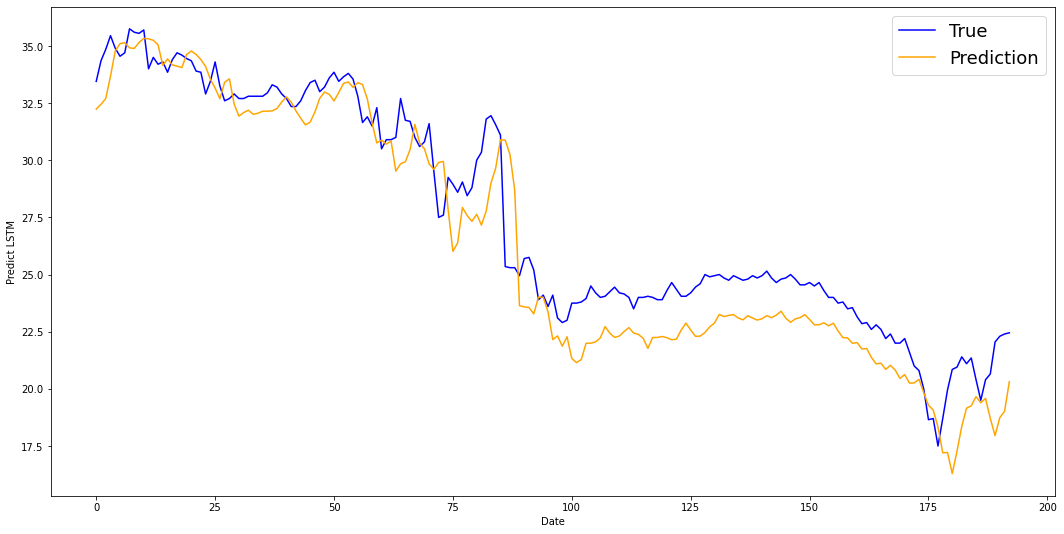

In [19]:
plt.figure(figsize = (18,9))
print(y_test.shape[0])
plt.plot(range(y_test.shape[0]),y_test,color='b',label='True')
plt.plot(range(y_predict.shape[0]),y_predict,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Predict LSTM')
plt.legend(fontsize=18)
plt.show()

In [20]:
def predict_LSTM(file_name, stock_name):
  df = pd.read_csv(file_name).sort_values('date')
  prices = df['close'].to_numpy()

  df_length = df.shape[0]
  train_length = df_length * 90 // 100
  test_length = df_length * 10 // 100

  train_data = prices[:train_length]
  test_data = prices[train_length:]

  train_data = train_data.reshape(-1,1)
  test_data = test_data.reshape(-1,1)

  time_steps = 3
  x_train = []
  y_train = []

  for i in range(time_steps, train_data.shape[0]):
      x_train.append(train_data[i - time_steps:i])
      y_train.append(train_data[i, 0])

  x_train = np.array(x_train)
  y_train = np.array(y_train)

  x_test = []
  y_test = []

  for i in range(time_steps, test_data.shape[0]):
      x_test.append(test_data[i - time_steps:i])
      y_test.append(test_data[i, 0])

  x_test = np.array(x_test)
  y_test = np.array(y_test)

  model = Sequential()
  model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(units=50))
  model.add(Dropout(0.5))
  model.add(Dense(units=1))
  model.summary()

  defined_metrics = [
    tf.keras.metrics.MeanSquaredError(name='MSE')
  ]

  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=defined_metrics)
  history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test),
                      callbacks=[callback])
  
  y_predict = model.predict(x_test)

  plt.figure(figsize = (18,9))
  print(y_test.shape[0])
  plt.plot(range(y_test.shape[0]),y_test,color='b',label='True')
  plt.plot(range(y_predict.shape[0]),y_predict,color='orange',label='Prediction')
  #plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
  plt.xlabel('Date')
  plt.ylabel('Predict LSTM')
  plt.legend(fontsize=18)
  plt.show()

  print("\n")
  print("============== {} ==============".format(stock_name))
  print("MSE: {}".format(mean_squared_error(y_test, y_predict)))
  print("MAPE: {}".format(mean_absolute_percentage_error(y_test, y_predict)))
  print("MAE: {}".format(mean_absolute_error(y_test, y_predict)))
  print("\n")


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 100)            40800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 100)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 50)             30200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)               

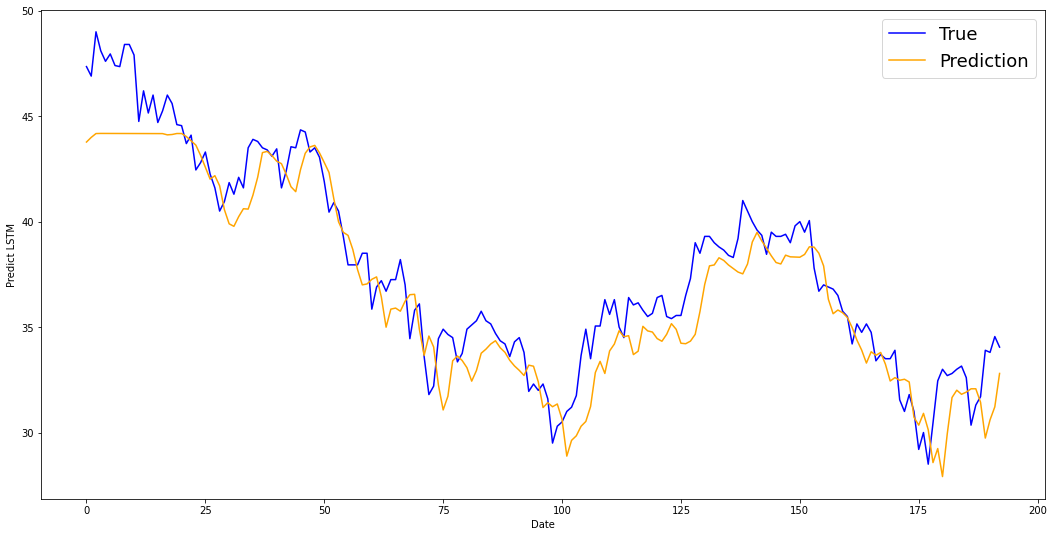



============== BID ==============
MSE: 3.2974867461989477
MAPE: 0.038111139566067515
MAE: 1.4373397669026269


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 3, 100)            40800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 100)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 3, 50)             30200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 3, 50)             20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 50)             0         
_______

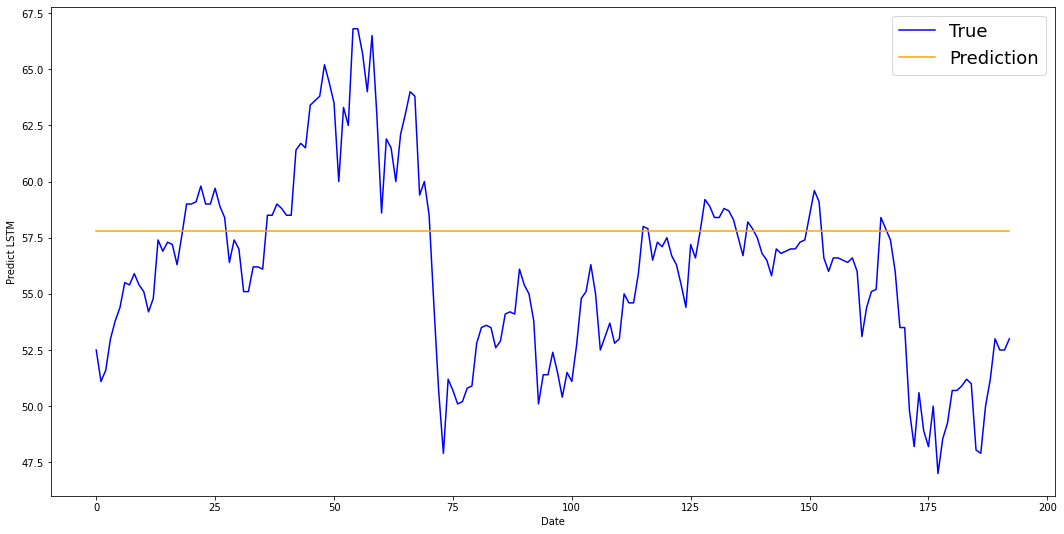



============== BVH ==============
MSE: 19.960631968429254
MAPE: 0.06507980069458365
MAE: 3.5316651497480165


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 50)             30200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 3, 50)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 50)             20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 3, 50)             0         
________

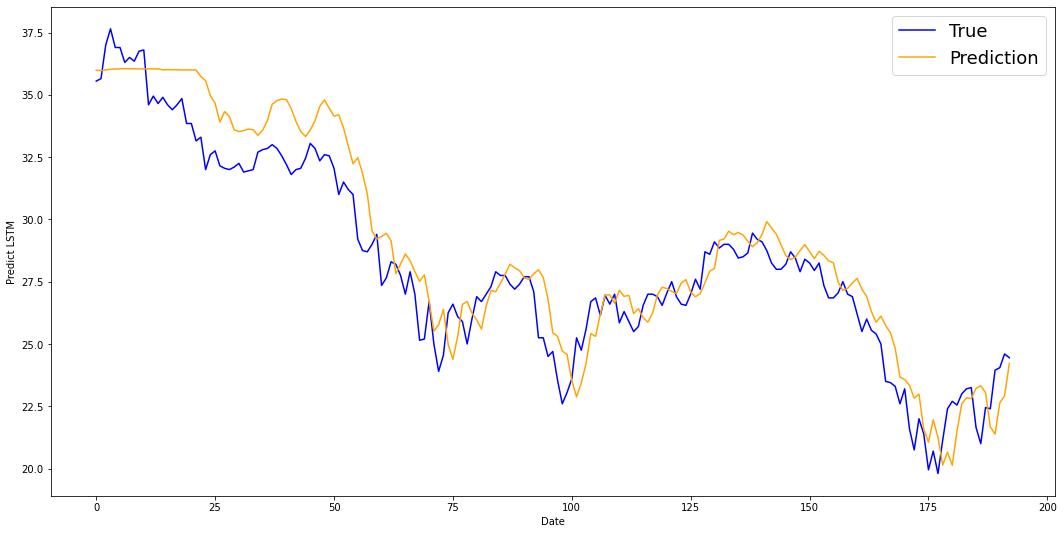



============== CTG ==============
MSE: 1.9499960401184895
MAPE: 0.04166364181290443
MAE: 1.1571587498323905


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
dropout_16 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 3, 50)             30200     
_________________________________________________________________
dropout_17 (Dropout)         (None, 3, 50)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 3, 50)             20200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 3, 50)             0         
________

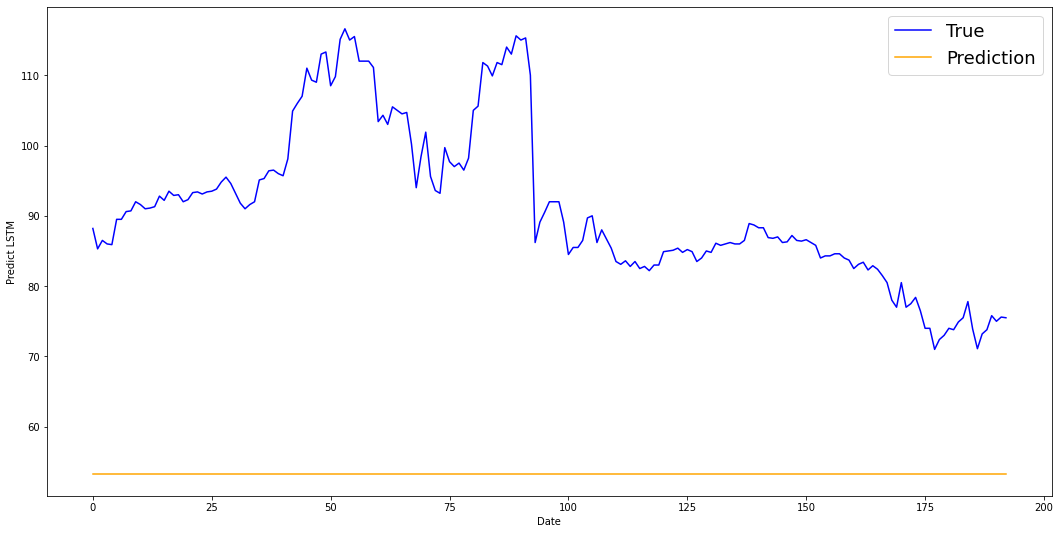



============== FPT ==============
MSE: 1566.4684835342898
MAPE: 0.4071266697268162
MAE: 37.947115689608715


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
dropout_20 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 3, 50)             30200     
_________________________________________________________________
dropout_21 (Dropout)         (None, 3, 50)             0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 3, 50)             20200     
_________________________________________________________________
dropout_22 (Dropout)         (None, 3, 50)             0         
_________

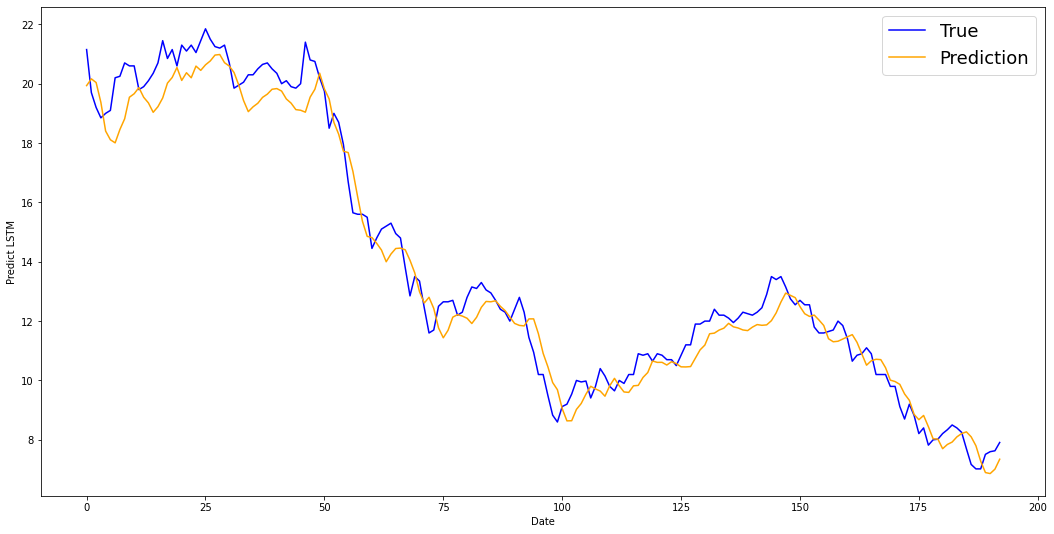



============== AGR ==============
MSE: 0.5700497718843073
MAPE: 0.04606789561604846
MAE: 0.6176394480374193


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
dropout_24 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 3, 50)             30200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 3, 50)             0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 3, 50)             20200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 3, 50)             0         
________

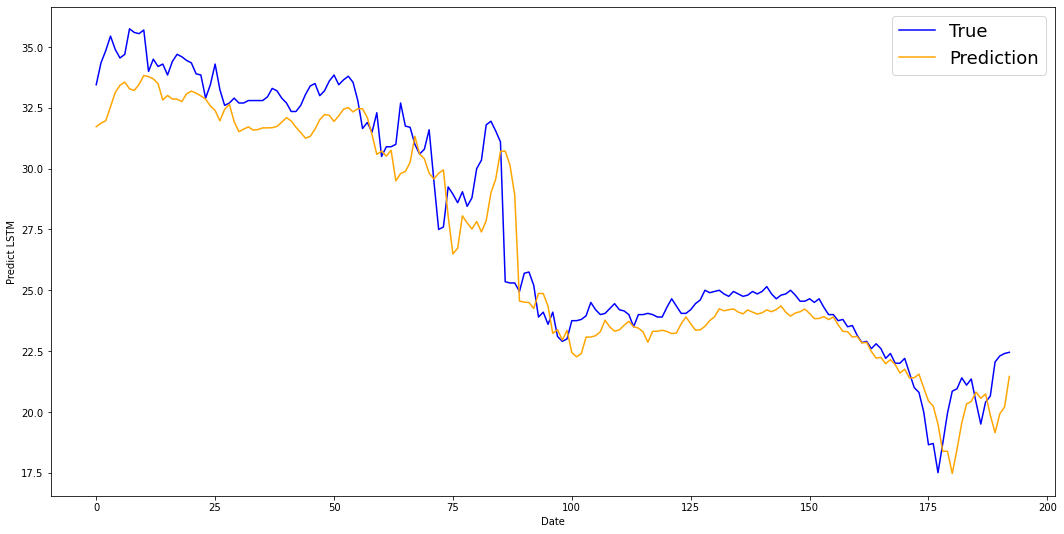



============== ACB ==============
MSE: 1.975654400835546
MAPE: 0.04021720792652397
MAE: 1.1034929344691142




In [21]:
stock_list = ["BID", "BVH", "CTG", "FPT", "AGR", "ACB"]
file_name_list = []

for s in stock_list:
  file_name_list.append("my-drive/MyDrive/" + s + "_2015.csv")


for i in range(0, len(file_name_list)):
  predict_LSTM(file_name_list[i], stock_list[i])


## Another stock

In [22]:
def evaluate_another_stock(file_name, stock_name):
  df = pd.read_csv(file_name).sort_values('date')

  # plt.figure(figsize = (18,9))
  # plt.plot(range(df.shape[0]),(df['close']))
  # plt.xticks(range(0,df.shape[0],1951),df['date'].loc[::1951])
  # plt.xlabel('Date',fontsize=18)
  # plt.ylabel('Close Price',fontsize=18)
  # plt.show()

  prices = df['close'].to_numpy()

  test_data = prices
  # test_data = prices[1561:]

  print("Test: {}".format(test_data.shape[0]))

  test_data = test_data.reshape(-1,1)

  y_test = []
  x_test = []

  time_steps = 3

  for i in range(time_steps, test_data.shape[0]):
      x_test.append(test_data[i - time_steps:i])
      y_test.append(test_data[i, 0])

  x_test = np.array(x_test)
  y_test = np.array(y_test)
  
  y_predict = model.predict(x_test)

  plt.figure(figsize = (18,9))
  plt.plot(range(y_test.shape[0]),y_test,color='b',label='True')
  plt.plot(range(y_predict.shape[0]),y_predict,color='orange',label='Prediction')
  plt.xlabel(stock_name)
  plt.ylabel('Predict LSTM')
  plt.legend(fontsize=18)
  plt.show()


Test: 1955


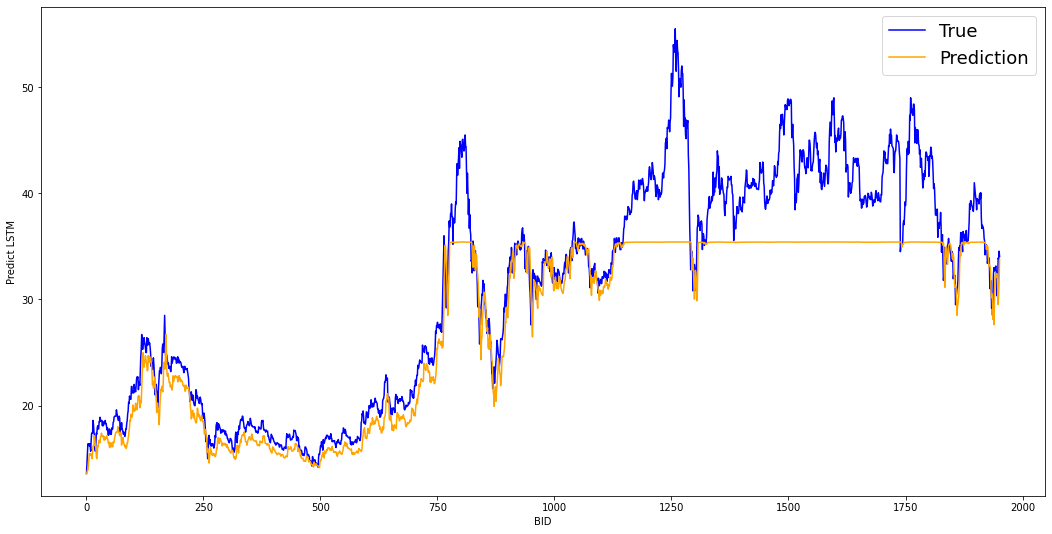

Test: 1955


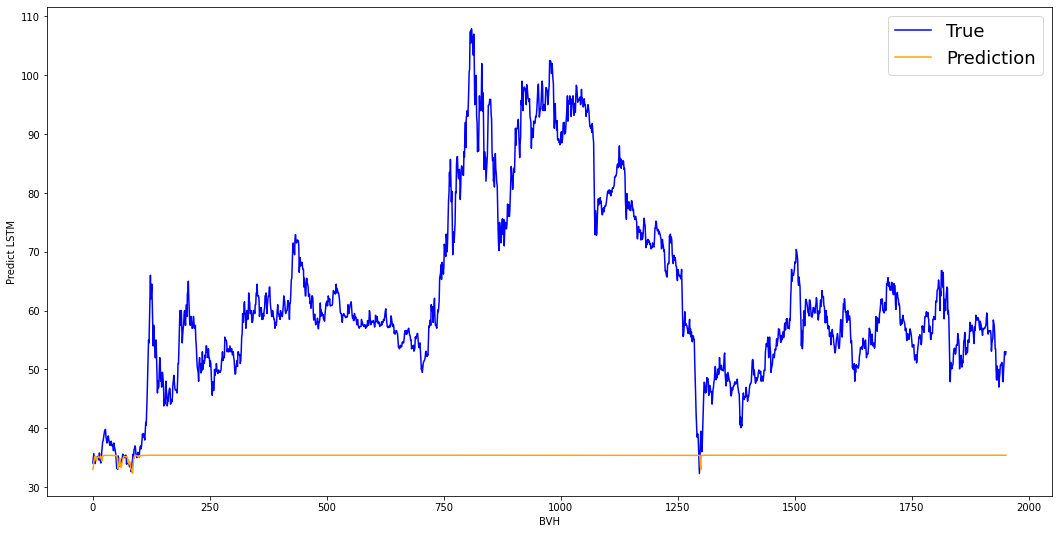

Test: 1955


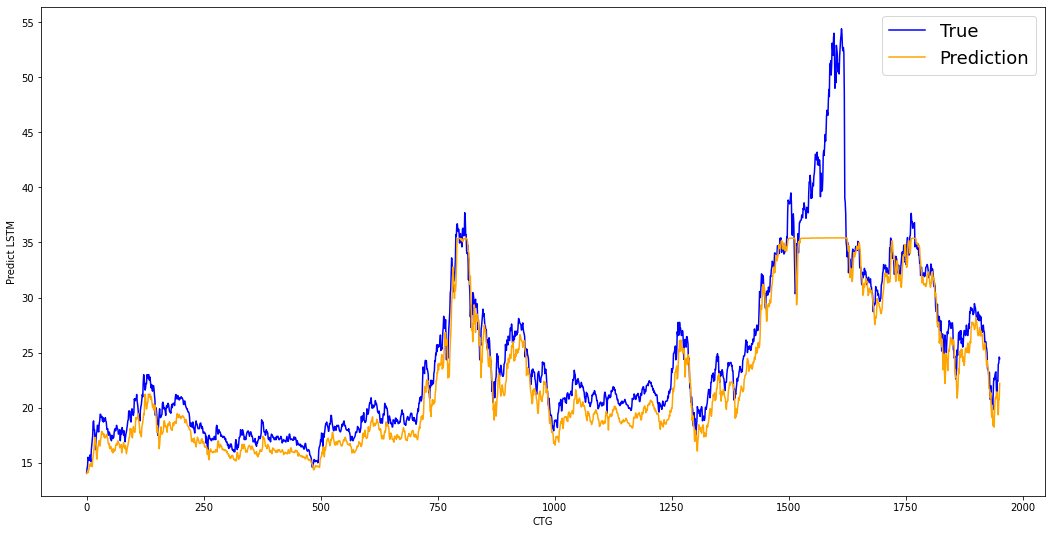

Test: 1954


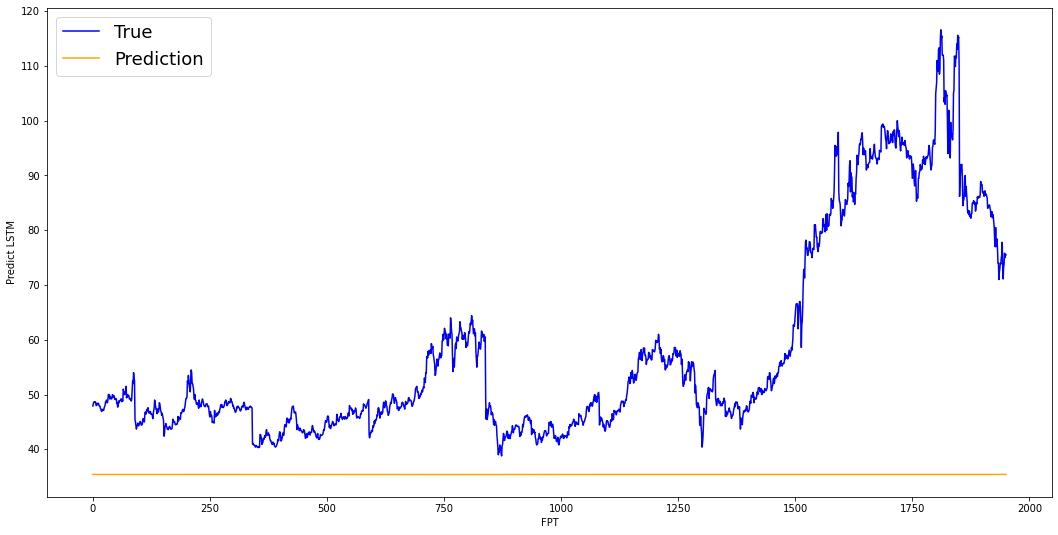

Test: 1954


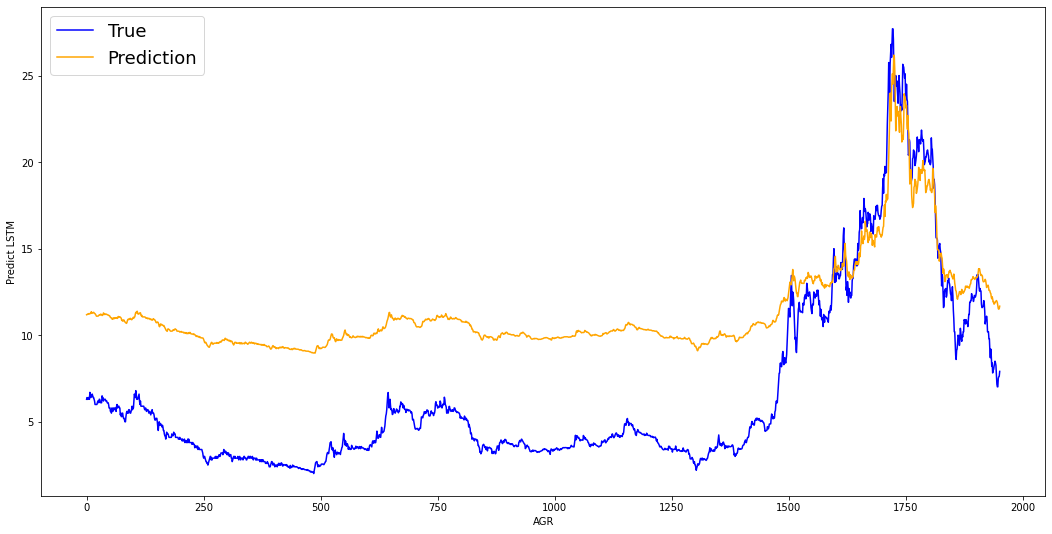

In [23]:
stock_list = ["BID", "BVH", "CTG", "FPT", "AGR"]
file_name_list = []

for s in stock_list:
  file_name_list.append("my-drive/MyDrive/" + s + "_2015.csv")


for i in range(0, len(file_name_list)):
  evaluate_another_stock(file_name_list[i], stock_list[i])
